# Pascal VOC2012 语义分割数据集

## 1. 数据集下载

语义分割的一个重要数据集叫作Pascal VOC2012 [1]。为了更好地了解这个数据集，我们先导入实验所需的包或模块。

我们先下载这个数据集的压缩包（[下载地址](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar)）。压缩包大小是2 GB左右，下载需要一定时间。下载后解压得到VOCdevkit/VOC2012文件夹，然后将其放置在data文件夹下。

这里已经提前下载存储到：
/home/teacher/notebooks/cv_project_2days/object_detection/data/VOCdevkit/VOC2012


解压后包含：

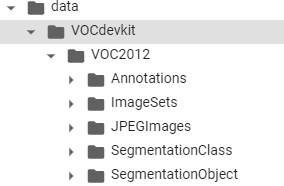

```
Annotations        JPEGImages         SegmentationObject
ImageSets          SegmentationClass
```



进入data/VOCdevkit/VOC2012路径后，我们可以获取数据集的不同组成部分。其中ImageSets/Segmentation路径包含了指定训练和测试样本的文本文件，而JPEGImages和SegmentationClass路径下分别包含了样本的输入图像和标签。这里的标签也是图像格式，其尺寸和它所标注的输入图像的尺寸相同。标签中颜色相同的像素属于同一个语义类别。下面定义read_voc_images函数将输入图像和标签读进内存。

train.txt文件内容如下：



```
2007_000032
2007_000039
2007_000063
2007_000068
2007_000121
2007_000170
...
```



In [7]:
import time
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
import os
sys.path.append("..")

检查数据集文件夹

In [8]:
voc_dir = "../../object_detection/data/VOCdevkit/VOC2012" # linux
# voc_dir = r"G:\deep_learning_data\VOCdevkit\VOC2012"
dirs_lst = os.listdir(voc_dir)
print(dirs_lst)


['Annotations', 'ImageSets', 'JPEGImages', 'SegmentationClass', 'SegmentationObject']


## 2.观察样本

In [9]:
fname="2007_000032"

(281, 500, 3)


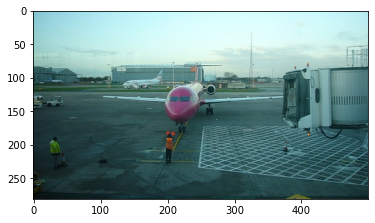

In [10]:
feature = tf.io.read_file('%s/JPEGImages/%s.jpg' % (voc_dir, fname))
feature = tf.image.decode_jpeg(feature)
print(feature.shape)   #(h, w, c)
plt.imshow(feature)

(281, 500, 3)


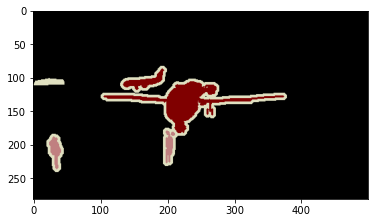

In [11]:
label = tf.io.read_file('%s/SegmentationClass/%s.png' % (voc_dir, fname))
label = tf.image.decode_png(label)

print(label.shape)
plt.imshow(label)   #(h, w, c)

In [12]:
def read_voc_images(root,  is_train=True, max_num=None):
    txt_fname = '%s/ImageSets/Segmentation/%s' % (root, 'train.txt' if is_train else 'val.txt') # 获取txt文件路径
    
    with open(txt_fname, 'r') as f:
        images = f.read().split()  # 获取图片名称
        
    if max_num is not None:
        images = images[:min(max_num, len(images))] # 截取 max_num张图片
        
    features, labels = [None] * len(images), [None] * len(images) # 创建空list
    
    for i, fname in tqdm(enumerate(images)):
        feature_tmp = tf.io.read_file('%s/JPEGImages/%s.jpg' % (root, fname))  # 读取图片
        features[i] = tf.image.decode_jpeg(feature_tmp)                        # 存入列表中
        
        label_tmp = tf.io.read_file('%s/SegmentationClass/%s.png' % (root, fname)) # 读取标签
        labels[i] = tf.image.decode_png(label_tmp)                              # 存入列表中
        
    return features, labels # shape=(h, w, c)

In [13]:
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

In [14]:
train_features, train_labels = read_voc_images(voc_dir, max_num=10)

10it [00:00, 104.21it/s]


我们画出前5张输入图像和它们的标签。在标签图像中，白色和黑色分别代表边框和背景，而其他不同的颜色则对应不同的类别。

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

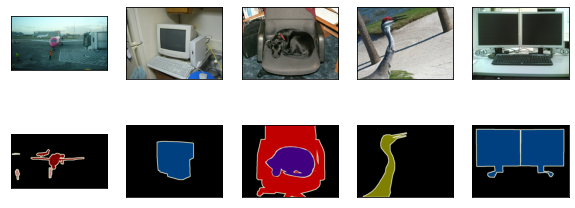

In [15]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
show_images(imgs, 2, n)

## 3. 标签转换
接下来，我们列出标签中每个RGB颜色的值及其标注的类别。

In [16]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

### 有了上面定义的两个常量以后，我们可以很容易地查找标签中每个像素的类别索引
### 颜色编码规则  (R\*256 + G)\*256 + B   


In [17]:
colormap2label = np.zeros(256 ** 3, dtype=np.uint8)  # 256 ** 3 = 1677 7216

for i, colormap in enumerate(VOC_COLORMAP):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i  # 颜色编码规则  (R*256 + G)*256 + B 
    
colormap2label = tf.convert_to_tensor(colormap2label)

###  第1类，[128, 0, 0], 在16777216中排序在   (128\*256 + 0)\*256 +0 =8388608

In [18]:
colormap2label[8388608]

<tf.Tensor: shape=(), dtype=uint8, numpy=1>

###  第2类，[0, 128, 0], 在16777216中排序在   (0\*256 + 128)\*256 +0 =32768

In [19]:
colormap2label[32768] # 可以通过指定的index返回对应的类

<tf.Tensor: shape=(), dtype=uint8, numpy=2>

### 例如，第一张样本图像中飞机头部区域的类别索引为1，而背景全是0。

In [20]:
def voc_label_indices(colormap, colormap2label):
    """
    convert colormap (tf image) to colormap2label (uint8 tensor).
    """
    colormap = tf.cast(colormap, dtype=tf.int32)
    idx = tf.add(tf.multiply(colormap[:, :, 0], 256), colormap[:, :, 1])
    idx = tf.add(tf.multiply(idx, 256), colormap[:, :, 2])
    idx = tf.add(idx, colormap[:, :, 2])
    return tf.gather_nd(colormap2label, tf.expand_dims(idx, -1))

In [21]:
y = voc_label_indices(train_labels[0], colormap2label)  # tf.image
y[105:115, 130:140], VOC_CLASSES[1] # 图像比较大，只截取了有目标的部分

(<tf.Tensor: shape=(10, 10), dtype=uint8, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]], dtype=uint8)>,
 'aeroplane')

## 4. 数据预处理——random crop

在语义分割里，这样做需要将预测的像素类别重新映射回原始尺寸的输入图像。  
这样的映射难以做到精确，尤其在不同语义的分割区域。为了避免这个问题，我们将图像裁剪成固定尺寸而不是缩放。  
具体来说，我们使用图像增广里的随机裁剪，并对输入图像和标签裁剪相同区域。

In [22]:
def voc_rand_crop(feature, label, height, width):
    """
    Random crop feature (tf image) and label (tf image).
    先将channel合并，剪裁之后再分开
    """
    combined = tf.concat([feature, label], axis=2)
    last_label_dim = tf.shape(label)[-1]
    last_feature_dim = tf.shape(feature)[-1]
    combined_crop = tf.image.random_crop(combined,
                        size=tf.concat([(height, width), [last_label_dim + last_feature_dim]],axis=0))
    return combined_crop[:, :, :last_feature_dim], combined_crop[:, :, last_feature_dim:]

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

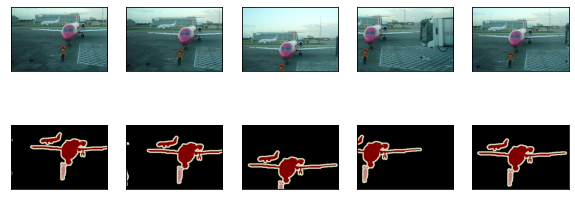

In [23]:
imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
show_images(imgs[::2] + imgs[1::2], 2, n)

## 5.定义数据集类

定义一个获取语义分割数据集函数getVOCSegDataset。  
由于数据集中有些图像的尺寸可能小于随机裁剪所指定的输出尺寸，这些样本需要通过自定义的filter函数所移除。  
此外，我们还对输入图像的RGB三个通道的值分别做标准化。

In [24]:
def getVOCSegDataset(is_train, crop_size, voc_dir, colormap2label, max_num=None):
    """
    crop_size: (h, w)
    """
    features, labels = read_voc_images(root=voc_dir, 
                        is_train=is_train,
                        max_num=max_num)
    def _filter(imgs, crop_size):
        return [img for img in imgs if (
            img.shape[0] >= crop_size[0] and
            img.shape[1] >= crop_size[1])]
    
    def _crop(features, labels):
        features_crop = []
        labels_crop = []
        for feature, label in zip(features, labels):
            feature, label = voc_rand_crop(feature, label, 
                            height=crop_size[0],
                            width=crop_size[1])
            features_crop.append(feature)
            labels_crop.append(label)
        return features_crop, labels_crop
    
    def _normalize(feature, label):
        # 通过imagenet 经验值 数据集统计得来的RGB三通道均值、标准差，自然图像下通用
        rgb_mean = np.array([0.485, 0.456, 0.406])  # 都是通过像素值/255得到
        rgb_std = np.array([0.229, 0.224, 0.225])
        # 其实以上代码并没有使用
        label = voc_label_indices(label, colormap2label)
        feature = tf.cast(feature, tf.float32)
        feature = tf.divide(feature, 255.)

        return feature, label

    features = _filter(features, crop_size)  # 超出部分过滤掉
    labels = _filter(labels, crop_size)
    features, labels = _crop(features, labels)

    print('read ' + str(len(features)) + ' valid examples')
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.map(_normalize)
    return dataset

### 读取数据集

我们通过自定义的getVOCSegDataset来分别创建训练集和测试集的实例。假设我们指定随机裁剪的输出图像的形状为320×400。下面我们可以查看训练集和测试集所保留的样本个数。

In [25]:
crop_size = (320, 400)
max_num = 100

voc_train = getVOCSegDataset(True, crop_size, voc_dir, colormap2label, max_num)
voc_test = getVOCSegDataset(False, crop_size, voc_dir, colormap2label, max_num)

100it [00:01, 99.63it/s]


read 77 valid examples


100it [00:00, 102.54it/s]


read 82 valid examples


设批量大小为64，分别定义训练集和测试集的迭代器。

In [26]:
batch_size = 64
voc_train = voc_train.batch(batch_size)
voc_test = voc_test.batch(batch_size)

In [27]:
for x, y in iter(voc_train):
    print(x.dtype, x.shape)
    print(y.dtype, y.shape)
    break

<dtype: 'float32'> (64, 320, 400, 3)
<dtype: 'uint8'> (64, 320, 400)
